#1. Kết nối Dataset và Xử lý dữ liệu

In [ ]:
# Kết nối Google Drive (chỉ cần trên Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pickle

# Đường dẫn tới thư mục huấn luyện
train_path = '/content/drive/MyDrive/Skin_Diseases/train3'

# Lấy danh sách các lớp từ thư mục train (giả định mỗi thư mục con là một lớp)
class_names = sorted([folder for folder in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, folder))])

# Kiểm tra danh sách các lớp
print("Danh sách các lớp:", class_names)

# Khởi tạo LabelEncoder và huấn luyện nó với danh sách các lớp
le = LabelEncoder()
le.fit(class_names)

# Lưu LabelEncoder vào tệp 'label_encoder.pkl'
encoder_path = '/content/drive/MyDrive/Skin_Diseases/model/label_encoder_5.pkl'
with open(encoder_path, 'wb') as f:
    pickle.dump(le, f)

print(f"LabelEncoder đã được lưu tại: {encoder_path}")


Danh sách các lớp: ['Acne and Rosacea Photos', 'Eczema Photos', 'Seborrheic Keratoses and other Benign Tumors']
LabelEncoder đã được lưu tại: /content/drive/MyDrive/Skin_Diseases/model/label_encoder_5.pkl


#2. Tải dữ liệu và Chia tập Huấn luyện/Validation

In [ ]:
# Xử lý dữ liệu: Tải và chia tập huấn luyện và tập validation
train_data = []
val_data = []

for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    files = os.listdir(folder_path)
    num_train = int(0.8 * len(files))  # 80% train, 20% validation
    files_train = random.sample(files, num_train)
    files_val = list(set(files) - set(files_train))

    for file in files_train:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224, 224))  # ResNet101 yêu cầu kích thước ảnh 224x224
        train_data.append((img, folder))

    for file in files_val:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224, 224))
        val_data.append((img, folder))

print(f"Tổng số ảnh train: {len(train_data)}, tổng số ảnh validation: {len(val_data)}")


Tổng số ảnh train: 7103, tổng số ảnh validation: 1777


#3. Lập biểu đồ phân phối số lượng ảnh theo từng lớp

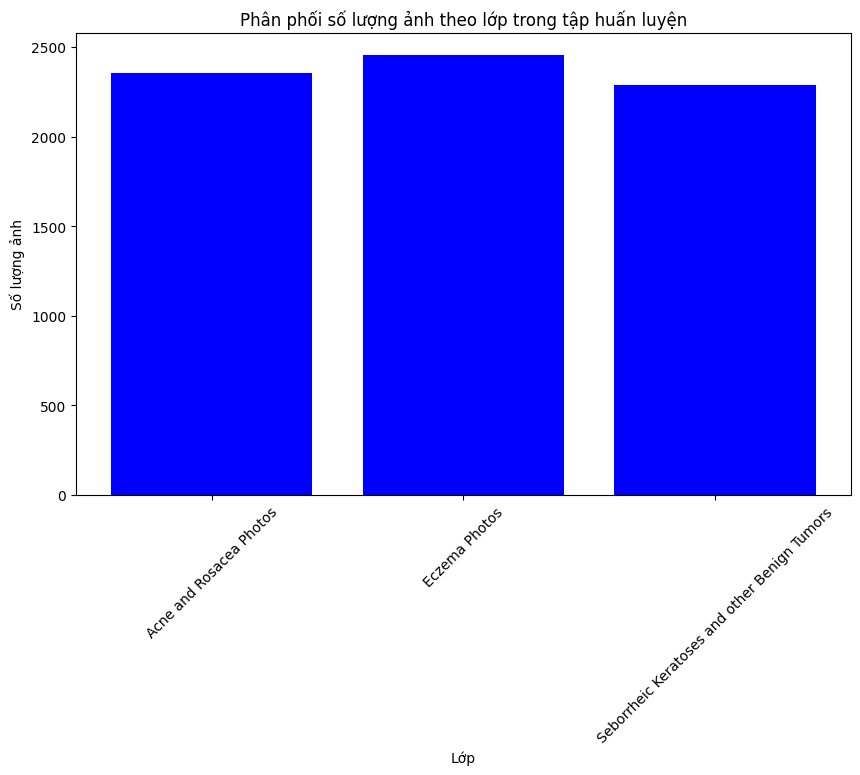

In [ ]:
# Vẽ biểu đồ phân phối số lượng ảnh theo lớp trong tập train
class_counts = {cls: len([img for img, label in train_data if label == cls]) for cls in class_names}

# Lập biểu đồ
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='b')
plt.xlabel("Lớp")
plt.ylabel("Số lượng ảnh")
plt.title("Phân phối số lượng ảnh theo lớp trong tập huấn luyện")
plt.xticks(rotation=45)
plt.show()


#4. Khởi tạo mô hình ResNet101 và Huấn luyện

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Khởi tạo mô hình ResNet101
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Đóng băng các lớp của ResNet101
base_model.trainable = False

# Tạo mô hình mới
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

# Compile mô hình
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Hàm chuyển đổi BGR sang LAB và resize ảnh
def convert_to_lab_and_resize(image):
    # Chuyển từ RGB (có thể là BGR) sang LAB
    img_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Chuyển RGB sang BGR nếu cần thiết
    img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)  # Chuyển BGR sang LAB
    return img_lab

# Chuyển đổi data sang dạng numpy array sau khi đã chuyển đổi sang LAB và resize
def resize_and_preprocess_lab(images):
    return np.array([preprocess_input(convert_to_lab_and_resize(img)) for img in images])

# Dữ liệu huấn luyện
X_train_resized = resize_and_preprocess_lab([img for img, label in train_data])
y_train = np.array([le.transform([label])[0] for img, label in train_data])

# Dữ liệu validation
X_val_resized = resize_and_preprocess_lab([img for img, label in val_data])
y_val = np.array([le.transform([label])[0] for img, label in val_data])

171446536/171446536 [==============================] - 1s 0us/step


In [ ]:
# Huấn luyện mô hình
history = model.fit(X_train_resized, y_train, validation_data=(X_val_resized, y_val), epochs=30)

Epoch 1/30
222/222 [==============================] - 220s 966ms/step - loss: 0.4944 - accuracy: 0.8181 - val_loss: 0.3233 - val_accuracy: 0.8700
Epoch 2/30
222/222 [==============================] - 212s 957ms/step - loss: 0.2793 - accuracy: 0.8964 - val_loss: 0.2934 - val_accuracy: 0.8858
Epoch 3/30
222/222 [==============================] - 211s 952ms/step - loss: 0.2201 - accuracy: 0.9175 - val_loss: 0.2483 - val_accuracy: 0.9015
Epoch 4/30
222/222 [==============================] - 208s 936ms/step - loss: 0.1588 - accuracy: 0.9437 - val_loss: 0.2568 - val_accuracy: 0.8970
Epoch 5/30
222/222 [==============================] - 205s 925ms/step - loss: 0.1287 - accuracy: 0.9549 - val_loss: 0.2819 - val_accuracy: 0.8948
Epoch 6/30
222/222 [==============================] - 207s 933ms/step - loss: 0.0924 - accuracy: 0.9665 - val_loss: 0.2101 - val_accuracy: 0.9336
Epoch 7/30
222/222 [==============================] - 209s 944ms/step - loss: 0.0673 - accuracy: 0.9779 - val_loss: 0.2075 -

In [ ]:
# Lưu mô hình đã huấn luyện
model.save('/content/drive/MyDrive/Skin_Diseases/model/my_model.h5')

#5. Đánh giá Mô hình với Precision, Recall, F1-score

In [ ]:
#5.1. Tính toán Precision, Recall, F1-Score, và Accuracy chi tiết

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

# Dữ liệu validation
X_val_resized = resize_and_preprocess_lab([img for img, label in val_data])
y_val = np.array([le.transform([label])[0] for img, label in val_data])

# Change X_val to X_val_resized for prediction:
y_pred = model.predict(X_val_resized)

# Dự đoán trên tập validation
y_pred_classes = np.argmax(y_pred, axis=1)

# Tính các chỉ số đánh giá cho toàn bộ tập validation
accuracy = accuracy_score(y_val, y_pred_classes)
precision = precision_score(y_val, y_pred_classes, average='weighted')  # Có thể là 'micro', 'macro' hoặc 'weighted'
recall = recall_score(y_val, y_pred_classes, average='weighted')
f1 = f1_score(y_val, y_pred_classes, average='weighted')

# In ra các kết quả đánh giá
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


56/56 [==============================] - 46s 791ms/step
Accuracy: 0.9465
Precision: 0.9468
Recall: 0.9465
F1-score: 0.9466


In [ ]:
# Báo cáo chi tiết về các chỉ số Precision, Recall, F1-score cho từng lớp
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, target_names=class_names))


Classification Report:
                                              precision    recall  f1-score   support

                     Acne and Rosacea Photos       0.93      0.95      0.94       589
                               Eczema Photos       0.97      0.96      0.96       615
Seborrheic Keratoses and other Benign Tumors       0.94      0.93      0.94       573

                                    accuracy                           0.95      1777
                                   macro avg       0.95      0.95      0.95      1777
                                weighted avg       0.95      0.95      0.95      1777



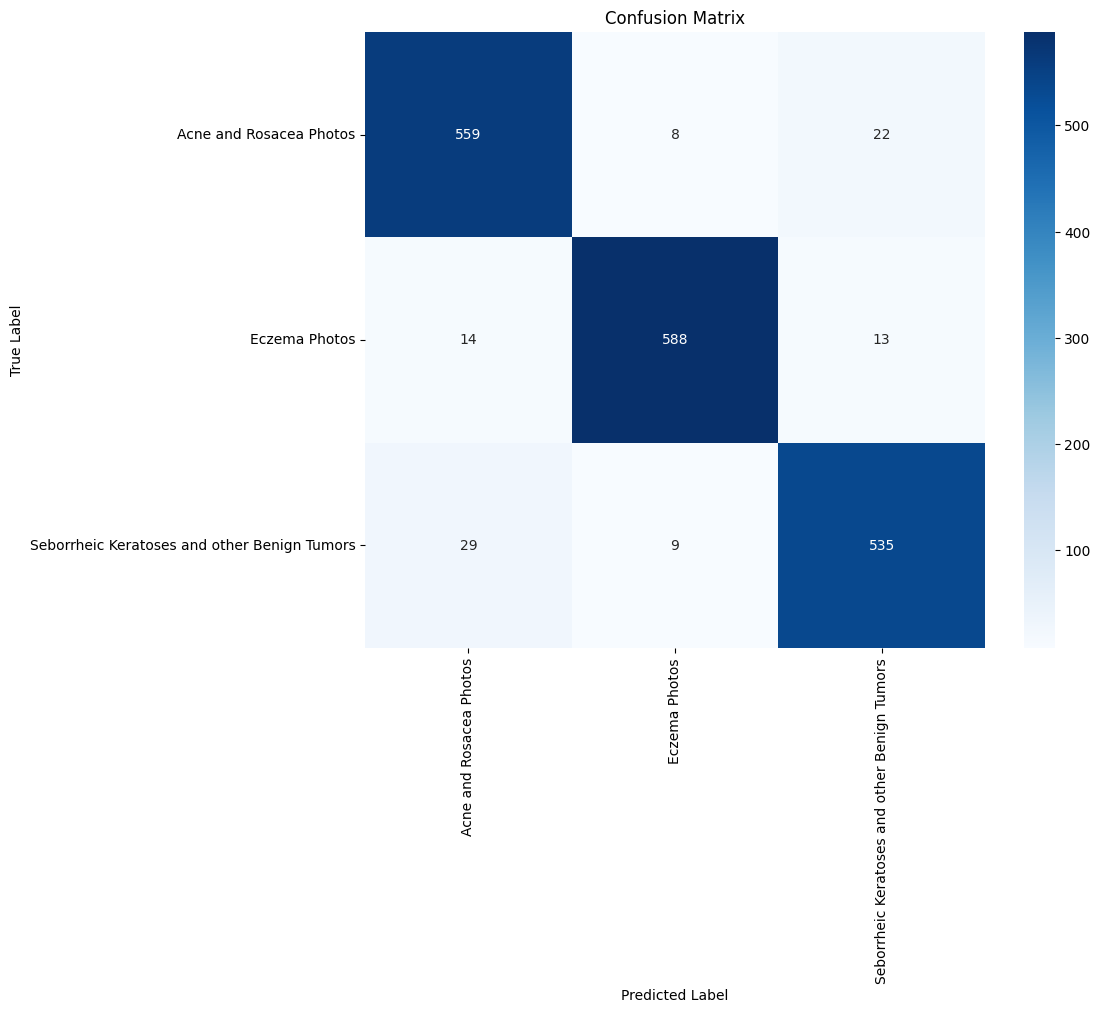

In [ ]:
#5.3. Ma trận nhầm lẫn (Confusion Matrix)

import seaborn as sns

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_val, y_pred_classes)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


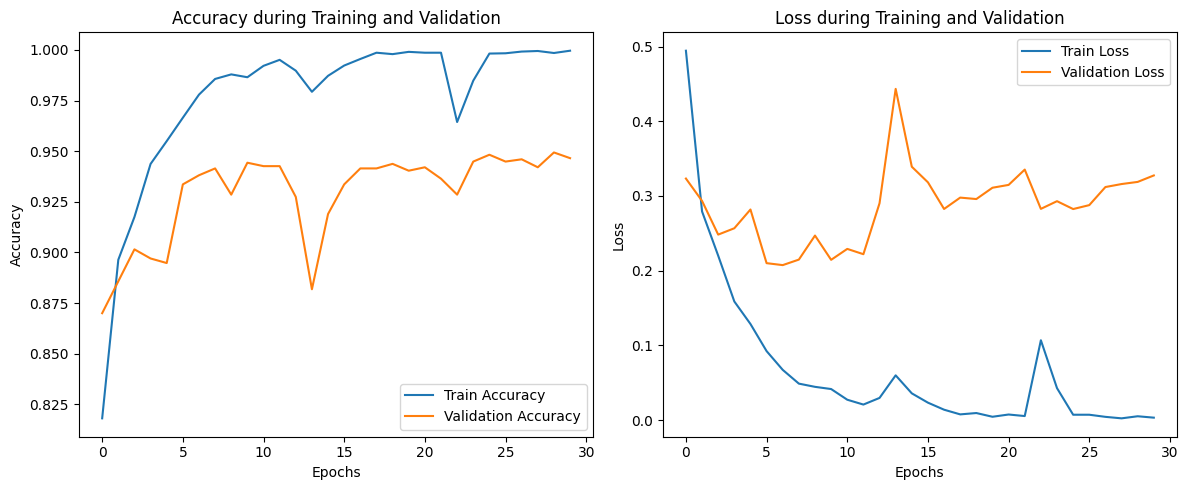

In [ ]:
#5.4. Vẽ biểu đồ quá trình huấn luyện (Accuracy và Loss)

# Vẽ biểu đồ Accuracy theo thời gian huấn luyện
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Vẽ biểu đồ Loss theo thời gian huấn luyện
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


#6. Test với 10 ảnh ngẫu nhiên


In [ ]:
# Đường dẫn tới thư mục test
test_path = '/content/drive/MyDrive/Skin_Diseases/test3'

# Khởi tạo danh sách chứa ảnh và nhãn của tập test
test_data = []

# Hàm chuyển đổi BGR sang LAB và resize ảnh
def convert_to_lab_and_resize(image):
    img_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Chuyển RGB sang BGR nếu cần thiết
    img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)  # Chuyển BGR sang LAB
    img_resized = cv2.resize(img_lab, (224, 224))  # Resize về kích thước 224x224
    return img_resized

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    files = os.listdir(folder_path)

    # Xử lý từng ảnh trong tập test
    for file in files:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)  # Đọc ảnh từ file
        img = convert_to_lab_and_resize(img)  # Chuyển đổi sang không gian màu LAB và resize
        test_data.append((img, folder))  # Lưu ảnh và nhãn

# Chuyển đổi dữ liệu thành mảng numpy
X_test = np.array([img for img, label in test_data])
y_test = np.array([le.transform([label])[0] for img, label in test_data])

print(f"Tổng số ảnh trong tập test: {len(X_test)}")

Tổng số ảnh trong tập test: 1409


45/45 [==============================] - 33s 738ms/step


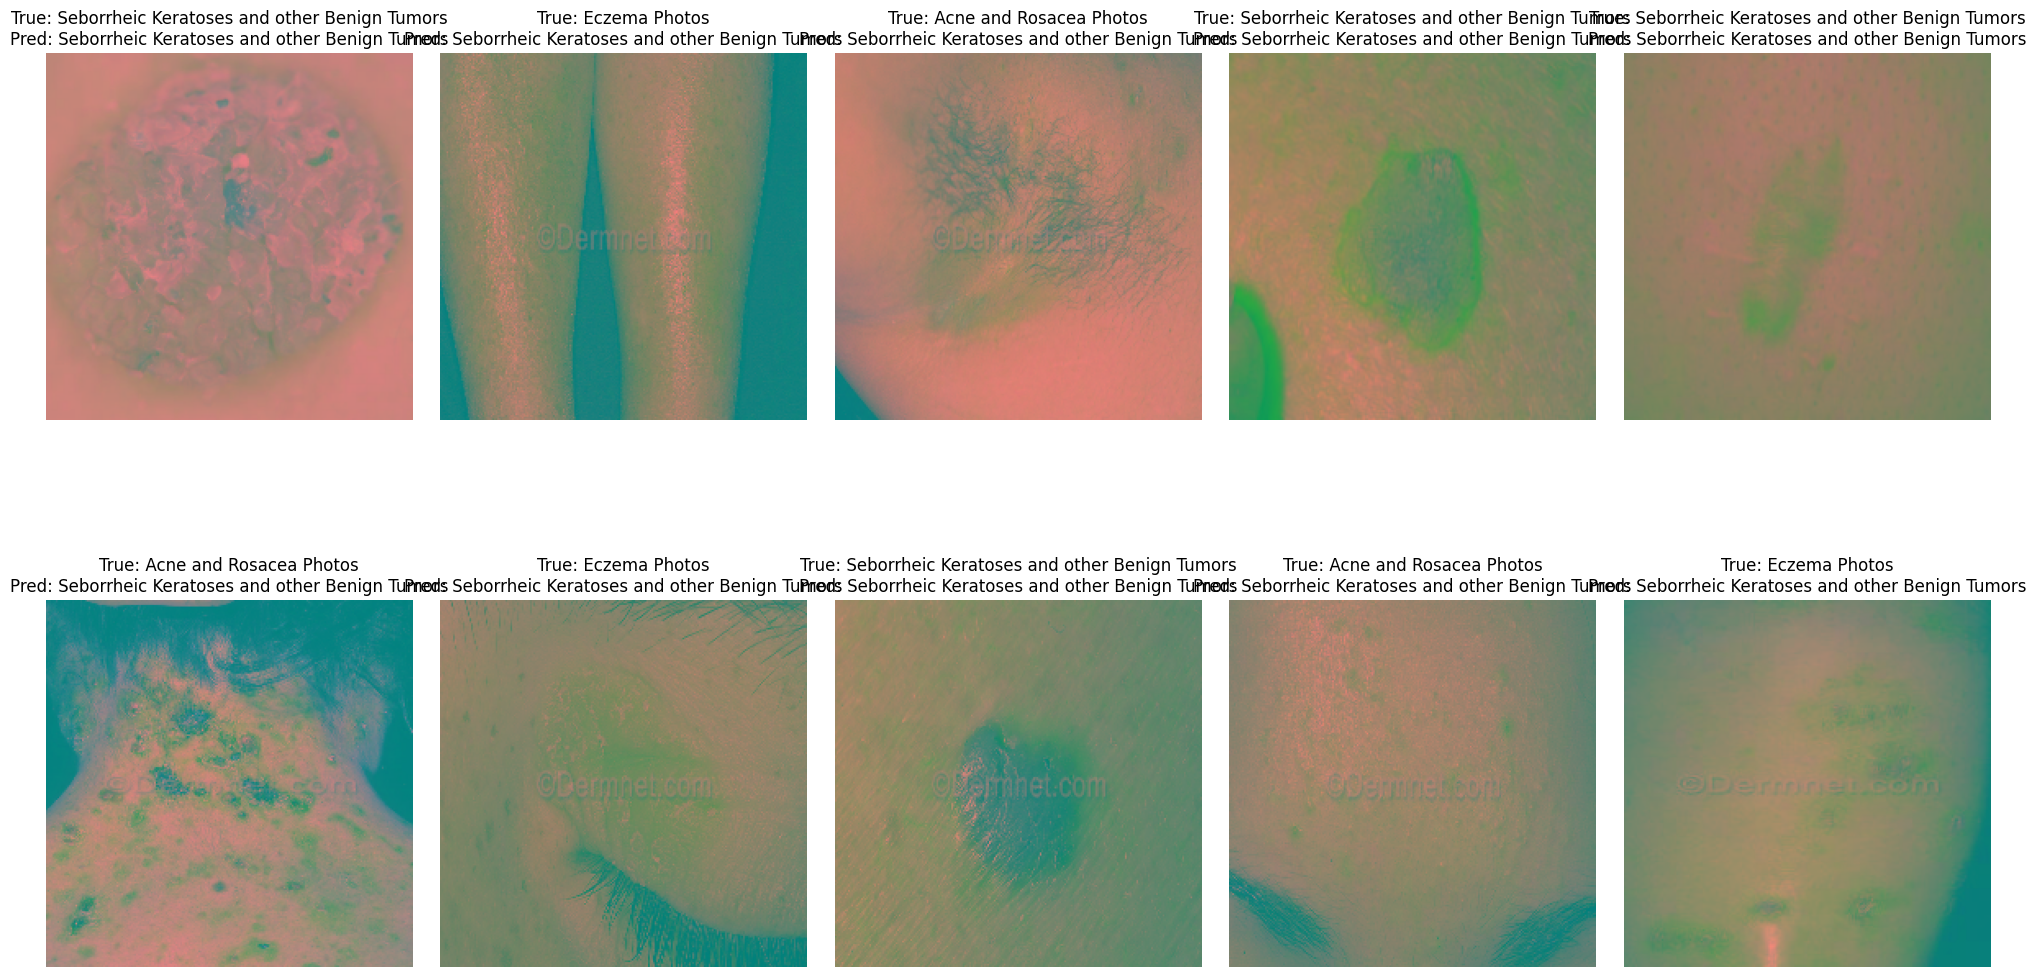

In [ ]:
# Lấy 10 ảnh ngẫu nhiên từ tập test
random_indices = random.sample(range(len(X_test)), 10)

# Dự đoán nhãn cho 10 ảnh này
y_pred_test = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

# Vẽ ảnh và so sánh nhãn thật với nhãn dự đoán
plt.figure(figsize=(20, 12))  # Tăng kích thước figure để có thêm không gian
for i, idx in enumerate(random_indices):
    img = X_test[idx]
    true_label = le.inverse_transform([y_test[idx]])[0]
    pred_label = le.inverse_transform([y_pred_test_classes[idx]])[0]

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=12)  # Điều chỉnh kích thước chữ tiêu đề
    plt.axis('off')

# Điều chỉnh khoảng cách giữa các hình ảnh và tiêu đề
plt.subplots_adjust(wspace=0.4, hspace=0.6)  # Điều chỉnh khoảng cách giữa các cột và dòng
plt.tight_layout(pad=2.0)  # Tăng khoảng cách giữa các phần tử trong layout

plt.show()
